In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error

original_data = pd.read_excel("Original_Data.xlsx", header = 3, usecols = "A:CC")
hull_data = pd.read_csv('Houseprice_data_scaled.csv') 

lr = lm.LinearRegression()
rg = lm.Ridge(alpha = 0.01)
ls = lm.Lasso(alpha = 0.01)

scaler = StandardScaler()


### Scaling the data

In [48]:
#Finding Optimal Alphas
def AlphaOptimizer(method, X_train, y_train, X_val, y_val):
    
    mses=[]
    
    if method == "Ridge":
        alphas=[0.01*1800, 0.02*1800, 0.03*1800, 0.04*1800, 0.05*1800, 0.075*1800,0.1*1800,0.2*1800, 0.4*1800]
        for alpha in alphas:
            ridge = lm.Ridge(alpha=alpha)
            ridge.fit(X_train,y_train)
            pred = ridge.predict(X_val)
            mses.append(mean_squared_error(y_val,pred))
            return min(mses)
        
    elif method == "Lasso":
        alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.075/2, 0.1/2]
        for alpha in alphas:
            lasso = lm.Lasso(alpha=alpha)
            lasso.fit(X_train,y_train)
            pred = lasso.predict(X_val)
            mses.append(mean_squared_error(y_val,pred))
            return min(mses)
        
    else:
        return("Not available method")

### Imputation Strategy 1: Replace missing data with the mean of data

In [49]:

imputed_data_1 = original_data.copy()

nan_map = imputed_data_1.isna()

mean = imputed_data_1["LotFrontage"].mean()

for i, row in nan_map.iterrows():
    if row['LotFrontage']:
        imputed_data_1["LotFrontage"][i] = mean

train1 = hull_data[:1800]

train1.insert(0, "LotFrontage", imputed_data_1.loc[:1799, ["LotFrontage"]].values)

val1 = hull_data[1800:2400]

val1.insert(0, "LotFrontage", imputed_data_1.loc[1800:2399, ["LotFrontage"]].values)

X_train1, X_val1 = train1.drop('Sale Price', axis=1), val1.drop('Sale Price', axis=1)
y_train1, y_val1 = train1[['Sale Price']], val1[['Sale Price']] 

X_train1 = scaler.fit_transform(X_train1)
X_val1 = scaler.transform(X_val1)

#Linear Regression
strat1_linear = lr.fit(X_train1, y_train1)
val1_lr_pred = strat1_linear.predict(X_val1)
print("Linear Regression:")
print("R-Score:", strat1_linear.score(X_train1, y_train1))
print("MSE:", mean_squared_error(y_val1, val1_lr_pred))

#Ridge
strat1_ridge = rg.fit(X_train1, y_train1)
val1_rg_pred = strat1_ridge.predict(X_val1)
print("\nRidge:")
print("R-Score:", strat1_ridge.score(X_train1, y_train1))
print("MSE:", AlphaOptimizer("Ridge", X_train1, y_train1, X_val1, y_val1))

#Lasso
strat1_lasso = ls.fit(X_train1, y_train1)
val1_ls_pred = strat1_lasso.predict(X_val1)
print("\nLasso:")
print("R-Score:", strat1_lasso.score(X_train1, y_train1))
print("MSE:", AlphaOptimizer("Lasso", X_train1, y_train1, X_val1, y_val1))

/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/3049792572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_1["LotFrontage"][i] = mean
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/3049792572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_1["LotFrontage"][i] = mean
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/3049792572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

Linear Regression:
R-Score: 0.8878587627685235
MSE: 0.11325046944616939

Ridge:
R-Score: 0.8878587627288108
MSE: 0.11326369106126818

Lasso:
R-Score: 0.8844910428276486
MSE: 0.11282838839994151


### Imputation Strategy 2: Replace missing data with the median of data

In [50]:

imputed_data_2 = original_data.copy()

nan_map = imputed_data_2.isna()

median = imputed_data_2["LotFrontage"].median()

for i, row in nan_map.iterrows():
    if row['LotFrontage']:
        imputed_data_2["LotFrontage"][i] = median

train2 = hull_data[:1800].copy()
val2 = hull_data[1800:2400].copy()

scaled_train_data = scaler.fit_transform(imputed_data_2.loc[:1799, ["LotFrontage"]])
scaled_val_data = scaler.fit_transform(imputed_data_2.loc[1800:2399, ["LotFrontage"]])

train2.insert(0, "LotFrontage", scaled_train_data)

val2.insert(0, "LotFrontage", scaled_val_data)

X_train2, X_val2 = train2.drop('Sale Price', axis=1), val2.drop('Sale Price', axis=1)
y_train2, y_val2 = train2[['Sale Price']], val2[['Sale Price']] 

X_train2 = scaler.fit_transform(X_train2)
X_val2 = scaler.transform(X_val2)

#Linear Regression
strat2_linear = lr.fit(X_train2, y_train2)
val2_lr_pred = strat2_linear.predict(X_val2)
print("Linear Regression:")
print("R-Score:", strat2_linear.score(X_train2, y_train2))
print("MSE:", mean_squared_error(y_val2, val2_lr_pred))

#Ridge
strat2_ridge = rg.fit(X_train2, y_train2)
val2_rg_pred = strat2_ridge.predict(X_val2)
print("\nRidge:")
print("R-Score:", strat2_ridge.score(X_train2, y_train2))
print("MSE:", AlphaOptimizer("Ridge", X_train2, y_train2, X_val2, y_val2))

#Lasso
strat2_lasso = ls.fit(X_train2, y_train2)
val2_ls_pred = strat2_lasso.predict(X_val2)
print("\nLasso:")
print("R-Score:", strat2_lasso.score(X_train2, y_train2))
print("MSE:", AlphaOptimizer("Lasso", X_train2, y_train2, X_val2, y_val2))

/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/510017610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_2["LotFrontage"][i] = median
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/510017610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_2["LotFrontage"][i] = median
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/510017610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Linear Regression:
R-Score: 0.887885687834035
MSE: 0.11312981468437366

Ridge:
R-Score: 0.8878856877940827
MSE: 0.1131429394936158

Lasso:
R-Score: 0.8845191770319231
MSE: 0.11269411665008434


/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/510017610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_2["LotFrontage"][i] = median
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/510017610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_2["LotFrontage"][i] = median
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/510017610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

### Imputation Strategy 3: Replace missing data with linear interpolation prediction

In [51]:
imputed_data_3 = original_data.copy()

nan_map = imputed_data_3.isna()

last_valid_value = imputed_data_3["LotFrontage"][imputed_data_3["LotFrontage"].first_valid_index()]

for i, row in nan_map.iterrows():
    if row['LotFrontage']:
        j = i
        while nan_map["LotFrontage"][j]:
            j += 1
        next_valid_value = imputed_data_3["LotFrontage"][j]
        imputed_data_3["LotFrontage"][i] = (next_valid_value + last_valid_value) / 2
    else:
        last_valid_value = imputed_data_3["LotFrontage"][i]

train3 = hull_data[:1800]

train3.insert(0, "LotFrontage", imputed_data_3.loc[:1799, ["LotFrontage"]].values)

val3 = hull_data[1800:2400]

val3.insert(0, "LotFrontage", imputed_data_3.loc[1800:2399, ["LotFrontage"]].values)

X_train3, X_val3 = train3.drop('Sale Price', axis=1), val3.drop('Sale Price', axis=1)
y_train3, y_val3 = train3[['Sale Price']], val3[['Sale Price']] 

X_train3 = scaler.fit_transform(X_train3)
X_val3 = scaler.transform(X_val3)

#Linear Regression
strat3_linear = lr.fit(X_train3, y_train3)
val3_lr_pred = strat3_linear.predict(X_val3)
print("Linear Regression:")
print("R-Score:", strat3_linear.score(X_train3, y_train3))
print("MSE:", mean_squared_error(y_val3, val3_lr_pred))

#Ridge
strat3_ridge = rg.fit(X_train3, y_train3)
val3_rg_pred = strat3_ridge.predict(X_val3)
print("\nRidge:")
print("R-Score:", strat3_ridge.score(X_train3, y_train3))
print("MSE:", AlphaOptimizer("Ridge", X_train3, y_train3, X_val3, y_val3))

#Lasso
strat3_lasso = ls.fit(X_train3, y_train3)
val3_ls_pred = strat3_lasso.predict(X_val3)
print("\nLasso:")
print("R-Score:", strat3_lasso.score(X_train3, y_train3))
print("MSE:", AlphaOptimizer("Lasso", X_train3, y_train3, X_val3, y_val3))

/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/1084089906.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_3["LotFrontage"][i] = (next_valid_value + last_valid_value) / 2
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/1084089906.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_data_3["LotFrontage"][i] = (next_valid_value + last_valid_value) / 2
/var/folders/z8/5wdvzpnn5msc6zhhnq9ztx580000gn/T/ipykernel_1078/1084089906.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

Linear Regression:
R-Score: 0.887542069212596
MSE: 0.1136372553103597

Ridge:
R-Score: 0.8875437620895418
MSE: 0.11364028204620207

Lasso:
R-Score: 0.8841481871317547
MSE: 0.11321248417972674


In [52]:
scaled_data = scaler.fit_transform(imputed_data_2.loc[:, ["LotFrontage"]])

data_a = hull_data.copy()
print(data_a)
data_a.insert(0, "LotFrontage", scaled_data)

print(scaled_data)
print(data_a)

       LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  BsmtFinSF1  \
0    -0.199572     0.652747    -0.512407   1.038851      0.875754    0.597837   
1    -0.072005    -0.072527     2.189741   0.136810     -0.432225    1.218528   
2     0.111026     0.652747    -0.512407   0.972033      0.827310    0.095808   
3    -0.077551     0.652747    -0.512407  -1.901135     -0.722887   -0.520319   
4     0.444919     1.378022    -0.512407   0.938624      0.730423    0.481458   
...        ...          ...          ...        ...           ...         ...   
2903 -0.922157    -1.523077     1.289025  -0.063644     -0.722887   -1.013221   
2904 -0.926816    -1.523077    -0.512407  -0.063644     -0.722887   -0.438169   
2905  1.081646    -0.797802     1.289025  -0.397733      0.536648    1.779888   
2906  0.021285    -0.797802    -0.512407   0.671352      0.342874   -0.244203   
2907 -0.069010     0.652747    -0.512407   0.704761      0.439761    0.716499   

      BsmtUnfSF  TotalBsmtS

### Part B: Adding Lot Shape

Lot Shape has 4 Categories. 
- let 0 = regular lot shape
- let 1 = slightly irregular
- let 2 = moderately irregular
- let 3 = irregular

### Create Categorical Variable

In [53]:
lot_shapes = []
for row in original_data['LotShape']:
    if row == 'Reg':
        lot_shapes.append(0)
    elif row == 'IR1':
        lot_shapes.append(1)
    elif row == 'IR2':
        lot_shapes.append(2)
    else:
        lot_shapes.append(3)

Lot_Shape = pd.DataFrame(lot_shapes, columns=['LotShape'])

print(Lot_Shape)

      LotShape
0            0
1            0
2            1
3            1
4            1
...        ...
2903         0
2904         0
2905         0
2906         0
2907         0

[2908 rows x 1 columns]


### Adding LotShape to DataFrame

In [54]:
data_b = pd.concat([data_a, Lot_Shape], axis=1)
data_b.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual,Sale Price,LotShape
0,-0.188463,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,...,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.358489,0
1,0.535895,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,...,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,10.905682,0.584308,0.008849,0
2,-0.043591,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,...,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.552733,1
3,-0.429915,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,...,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,-0.577852,-0.528560,1
4,0.729057,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,...,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.895898,1


### Linear Regression

In [55]:
train = data_b.iloc[:1800]
validation = data_b.iloc[1800:2400]
test = data_b.iloc[2400:2908]

X_train = train.drop('Sale Price', axis=1)
X_val = validation.drop('Sale Price', axis=1)
Y_train, Y_val = train[['Sale Price']], validation[['Sale Price']]

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)
prediction = linear_reg.predict(X_train)
mse = mean_squared_error(Y_train, prediction)
print("Training Set:")
print("MSE: "+ str(mse))
print("RMSE: " + str(np.sqrt(mse)))
print("MAE: " + str(mean_absolute_error(Y_train, prediction)))

prediction_val = linear_reg.predict(X_val)
mse_val = mean_squared_error(Y_val, prediction_val)
print("\nValidation Set:")
print("MSE:" + str(mse_val))
print("RMSE: " + str(np.sqrt(mse_val)))
print("MAE: " + str(mean_absolute_error(Y_val, prediction_val)))

Training Set:
MSE: 0.11198716827027992
RMSE: 0.33464483900141045
MAE: 0.22921383203053472

Validation Set:
MSE:0.11341357305866538
RMSE: 0.3367693172761815
MAE: 0.22663118453757125


In [57]:
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(linear_reg.intercept_) + list(linear_reg.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.007247
LotFrontage,0.055445
LotArea,0.069429
OverallQual,0.212792
OverallCond,0.097124
YearBuilt,0.164766
YearRemodAdd,0.027101
BsmtFinSF1,0.092344
BsmtUnfSF,-0.033028


### Lasso Regression, alpha = 0.1

In [58]:
# %%sql

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train, Y_train)
coeffs = pd.DataFrame([['intercept'] + list(X_train.columns),
        list(lasso_reg.intercept_) + list(lasso_reg.coef_)]).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotFrontage,0.0
LotArea,0.00714
OverallQual,0.322906
OverallCond,0.0
YearBuilt,0.033806
YearRemodAdd,0.038041
BsmtFinSF1,0.091042
BsmtUnfSF,-0.0


In [59]:
prediction = lasso_reg.predict(X_train)
mse = mean_squared_error(Y_train, prediction)
print("MSE: "+ str(mse))
print("RMSE: " + str(np.sqrt(mse)))
print("MAE: " + str(mean_absolute_error(Y_train, prediction)))
prediction1 = lasso_reg.predict(X_val)
mse1 = mean_squared_error(Y_train, prediction)
print(mse1)
print("RMSE: " + str(np.sqrt(mse1)))
print("MAE: " + str(mean_absolute_error(Y_train, prediction)))

MSE: 0.1725867973941036
RMSE: 0.41543567178818863
MAE: 0.27446886588626435
0.1725867973941036
RMSE: 0.41543567178818863
MAE: 0.27446886588626435


### Ridge Regression, alpha = 1

In [60]:
from sklearn.linear_model import Ridge

alpha = 1800*1
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, Y_train)
prediction = ridge_reg.predict(X_train)
mse = mean_squared_error(Y_train, prediction)
print("MSE: "+ str(mse))
print("RMSE: " + str(np.sqrt(mse)))
print("MAE: " + str(mean_absolute_error(Y_train, prediction)))
prediction1 = ridge_reg.predict(X_val)
mse1 = mean_squared_error(Y_train, prediction)
print("MSE: "+ str(mse1))
print("RMSE: " + str(np.sqrt(mse1)))
print("MAE: " + str(mean_absolute_error(Y_train, prediction)))

MSE: 0.11198753212475715
RMSE: 0.3346453826437131
MAE: 0.22918868163969086
MSE: 0.11198753212475715
RMSE: 0.3346453826437131
MAE: 0.22918868163969086


### Part C

## Additional Feature #1: House Style

### Creating Dummies for Types of House Style

In [61]:
HouseStyle_types = []
HouseStyle = {}

for i in original_data['HouseStyle']:
    if i not in HouseStyle_types:
        HouseStyle_types.append(i)
        HouseStyle[i] = []

for i in original_data['HouseStyle']:
    for j in range(len(HouseStyle_types)):
        if i == HouseStyle_types[j]:
            HouseStyle[HouseStyle_types[j]].append(1)
        else:
            HouseStyle[HouseStyle_types[j]].append(0)

HouseStyle = pd.DataFrame.from_dict(HouseStyle)
HouseStyle.drop('2Story', axis=1, inplace=True)
# 2Story is the omitted category, dropped this column from the data
HouseStyle.head()

,1Story,1.5Fin,1.5Unf,SFoyer,SLvl,2.5Unf,2.5Fin
0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


## Additional Feature #2: Exterior 1 Style

### Creating Dummies for Types of House Style

In [62]:
Exterior1st_types = []
Exterior1st = {}

for i in original_data['Exterior1st']:
    if i not in Exterior1st_types:
        Exterior1st_types.append(i)
        Exterior1st[i] = []

for i in original_data['Exterior1st']:
    for j in range(len(Exterior1st_types)):
        if i == Exterior1st_types[j]:
            Exterior1st[Exterior1st_types[j]].append(1)
        else:
            Exterior1st[Exterior1st_types[j]].append(0)

Exterior1st = pd.DataFrame.from_dict(Exterior1st)
Exterior1st = Exterior1st[Exterior1st.columns[:-1]]
Exterior1st.drop('VinylSd', axis=1, inplace=True)
# VinylSd is the omitted category, dropped this column from the data
Exterior1st.head()

,MetalSd,Wd Sdng,HdBoard,BrkFace,WdShing,CemntBd,Plywood,AsbShng,Stucco,BrkComm,AsphShn,Stone,ImStucc,CBlock
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Adding Additional Features to DataFrame

In [63]:
data_c = pd.concat([data_b, HouseStyle, Exterior1st], axis=1)
data_c = data_c[[col for col in data_c.columns if col != 'Sale Price'] + ['Sale Price']]

data_c.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,CemntBd,Plywood,AsbShng,Stucco,BrkComm,AsphShn,Stone,ImStucc,CBlock,Sale Price
0,-0.188463,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,...,0,0,0,0,0,0,0,0,0,0.358489
1,0.535895,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,...,0,0,0,0,0,0,0,0,0,0.008849
2,-0.043591,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,...,0,0,0,0,0,0,0,0,0,0.552733
3,-0.429915,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,...,0,0,0,0,0,0,0,0,0,-0.528560
4,0.729057,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,...,0,0,0,0,0,0,0,0,0,0.895898


## Linear regression

In [64]:
train = data_c.iloc[:1800] 
val = data_c.iloc[1800:2400]
test = data_c.iloc[2400:2908]

X_train = train.drop('Sale Price', axis=1)
X_val = val.drop('Sale Price', axis=1)
y_train, y_val = train[['Sale Price']], val[['Sale Price']]

In [65]:
lr=LinearRegression()
lr.fit(X_train,y_train)
pred=lr.predict(X_train)
print("Train MSE:", mean_squared_error(y_train,pred))
pred=lr.predict(X_val)
print("Validation MSE:", mean_squared_error(y_val,pred))

Train MSE: 0.10709947258964408
Validation MSE: 0.11113888113148614


In [66]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,180.666978
LotFrontage,0.053986
LotArea,0.070117
OverallQual,0.212831
OverallCond,0.096754
...,...
BrkComm,-0.257364
AsphShn,-0.172336
Stone,-0.353935


## Ridge regression

In [67]:
from sklearn.linear_model import Ridge

In [68]:
# Define Ridge Regression model
ridge = Ridge(alpha=1)  # Specify the alpha here

# Fit the Ridge Regression model on the training set
ridge.fit(X_train, y_train)

# Predictions on the training set
ridge_train_predictions = ridge.predict(X_train)

# Calculate MSE for the training set
ridge_train_mse = mean_squared_error(y_train, ridge_train_predictions)
print("MSE for Ridge training set:", ridge_train_mse)

# Predictions on the validation set
ridge_val_predictions = ridge.predict(X_val)

# Calculate MSE for the validation set
ridge_val_mse = mean_squared_error(y_val, ridge_val_predictions)
print("MSE for Ridge validation set:", ridge_val_mse)

MSE for Ridge training set: 0.10713773329352944
MSE for Ridge validation set: 0.11099184351280951


In [69]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
alphas=[0.01*1800, 0.02*1800, 0.03*1800, 0.04*1800, 0.05*1800, 0.075*1800,0.1*1800,0.2*1800, 0.6*1800, 1.0*1800]
mses=[]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_val)
    mses.append(mean_squared_error(y_val,pred))
    print(mean_squared_error(y_val,pred))

0.11045457052556479
0.11064386032380288
0.11093243998394181
0.1112589134117308
0.11160532053641203
0.11251833122855084
0.11347055947264754
0.11748253249426457
0.13486406925654937
0.1531804733960868


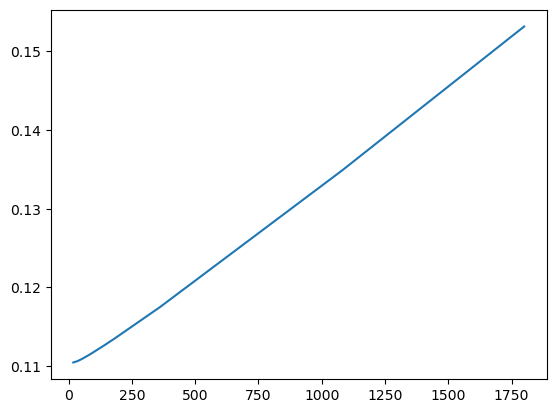

In [70]:
from matplotlib import pyplot as plt

plt.plot(alphas, mses)

## Lasso regression

In [71]:
from sklearn.linear_model import Lasso

In [72]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.000662
LotFrontage,0.049072
LotArea,0.06762
OverallQual,0.233574
OverallCond,0.071852
...,...
BrkComm,-0.0
AsphShn,-0.0
Stone,-0.0


### Lasso with different levels of alpha and its mse

In [73]:
lasso = Lasso(alpha=0.1)  # You can specify the alpha (regularization strength) here

# Fit the Lasso Regression model on the training set
lasso.fit(X_train, y_train)

# Predictions on the training set
lasso_train_predictions = lasso.predict(X_train)

# Calculate MSE for the training set
lasso_train_mse = mean_squared_error(y_train, lasso_train_predictions)
print("MSE for Lasso training set:", lasso_train_mse)

# Predictions on the validation set
lasso_val_predictions = lasso.predict(X_val)

# Calculate MSE for the validation set
lasso_val_mse = mean_squared_error(y_val, lasso_val_predictions)
print("MSE for Lasso validation set:", lasso_val_mse)


MSE for Lasso training set: 0.1725867973941036
MSE for Lasso validation set: 0.17249342233059142


In [74]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.075/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mean_squared_error(y_val,pred))
    print(mean_squared_error(y_val, pred))

0.11188837351628715
0.11275012277542662
0.11401937543641698
0.1164047869381299
0.11964924364129002
0.12972063298699624
0.13870965459370985


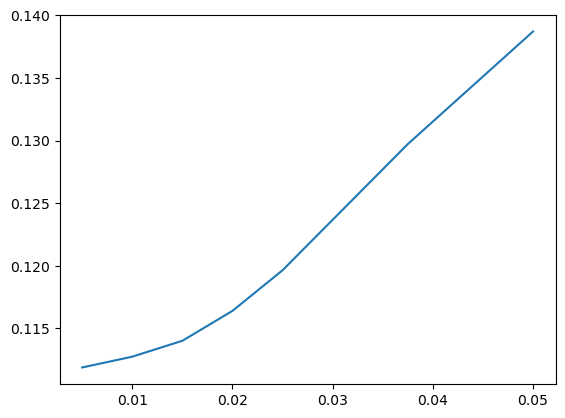

In [75]:
plt.plot(alphas, mses)

In [76]:
# Calculate mse for test set when Hull's lambda = 0.04
# alpha=0.04/2
# lasso=Lasso(alpha=alpha)
# lasso.fit(X_train,y_train)
# pred=lasso.predict(X_test)
# print(mean_squared_error(y_test,pred))

In [77]:
# Calculate mse for test set when Hull's lambda =0.1
# alpha=0.1/2
# lasso=Lasso(alpha=alpha)
# lasso.fit(X_train,y_train)
# pred=lasso.predict(X_test)
# print(mse(y_test,pred))

### Part D

In [78]:
# where data_c is the dataset chosen based on MSE, R^2, etc.
# shuffling the data
shuffled_data_x = data_c.sample(frac = 1)

In [79]:
# First 1800 data items are training set; the next 600 are the validation set; the remainder are in the test set
shuffled_train_x = shuffled_data_x.iloc[:1800] 
shuffled_val_x = shuffled_data_x.iloc[1800:2400]
shuffled_test_x = shuffled_data_x.iloc[2400:]

##### Assuming this step has already been done / is redundant for data_x

In [80]:
# Creating the "X" and "y" variables. We drop sale price from "X"
x_shuffled_train_x, x_shuffled_val_x, x_shuffled_test_x = shuffled_train_x.drop('Sale Price', axis=1), shuffled_val_x.drop('Sale Price', axis=1), shuffled_test_x.drop('Sale Price', axis=1)
y_shuffled_train_x, y_shuffled_val_x, y_shuffled_test_x = shuffled_train_x[['Sale Price']], shuffled_val_x[['Sale Price']], shuffled_test_x[['Sale Price']]

###### Linear Regression

In [81]:
# Importing models
from sklearn.linear_model import LinearRegression

In [82]:
# Fit the Linear Regression model on the training set
lr.fit(x_shuffled_train_x, y_shuffled_train_x)

# Predictions on the training set
train_predictions = lr.predict(x_shuffled_train_x)

# Calculate MSE for the training set
train_mse = mean_squared_error(y_shuffled_train_x, train_predictions)
print("MSE for training set:", train_mse)

# Predictions on the validation set
val_predictions = lr.predict(x_shuffled_val_x)

# Calculate MSE for the validation set
val_mse = mean_squared_error(y_shuffled_val_x, val_predictions)
print("MSE for validation set:", val_mse)

# Predictions on the test set
test_predictions = lr.predict(x_shuffled_test_x)

# Calculate MSE for the test set
test_mse = mean_squared_error(y_shuffled_test_x, test_predictions)
print("MSE for test set:", test_mse)

MSE for training set: 0.1088218834160837
MSE for validation set: 0.11356581071239878
MSE for test set: 0.10269407347013854


In [83]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.034658
LotFrontage,0.051423
LotArea,0.086875
OverallQual,0.238785
OverallCond,0.073664
...,...
BrkComm,-0.333997
AsphShn,-0.274853
Stone,-0.102023


###### Ridge Regression

In [84]:
# Importing Ridge
from sklearn.linear_model import Ridge

###### Ridge Regression MSE

In [85]:
# Define Ridge Regression model
ridge = Ridge(alpha=1)  # Specify the alpha here

# Fit the Ridge Regression model on the training set
ridge.fit(x_shuffled_train_x, y_shuffled_train_x)

# Predictions on the training set
ridge_train_predictions = ridge.predict(x_shuffled_train_x)

# Calculate MSE for the training set
ridge_train_mse = mean_squared_error(y_shuffled_train_x, ridge_train_predictions)
print("MSE for Ridge training set:", ridge_train_mse)

# Predictions on the validation set
ridge_val_predictions = ridge.predict(x_shuffled_val_x)

# Calculate MSE for the validation set
ridge_val_mse = mean_squared_error(y_shuffled_val_x, ridge_val_predictions)
print("MSE for Ridge validation set:", ridge_val_mse)

# Predictions on the test set
ridge_test_predictions = ridge.predict(x_shuffled_test_x)

# Calculate MSE for the test set
ridge_test_mse = mean_squared_error(y_shuffled_test_x, ridge_test_predictions)
print("MSE for Ridge test set:", ridge_test_mse)

MSE for Ridge training set: 0.10889309351169259
MSE for Ridge validation set: 0.11283053861729134
MSE for Ridge test set: 0.10254098346968597


###### Lasso

In [86]:
# Import Lasso
from sklearn.linear_model import Lasso

In [87]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [88]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotFrontage,0.0
LotArea,0.00714
OverallQual,0.322906
OverallCond,0.0
...,...
BrkComm,-0.0
AsphShn,-0.0
Stone,0.0


###### Lasso with different levels of alpha and its mse

###### Lasso regression MSE

In [89]:
# Define Lasso Regression model
lasso = Lasso(alpha=0.1)  # You can specify the alpha (regularization strength) here

# Fit the Lasso Regression model on the training set
lasso.fit(x_shuffled_train_x, y_shuffled_train_x)

# Predictions on the training set
lasso_train_predictions = lasso.predict(x_shuffled_train_x)

# Calculate MSE for the training set
lasso_train_mse = mean_squared_error(y_shuffled_train_x, lasso_train_predictions)
print("MSE for Lasso training set:", lasso_train_mse)

# Predictions on the validation set
lasso_val_predictions = lasso.predict(x_shuffled_val_x)

# Calculate MSE for the validation set
lasso_val_mse = mean_squared_error(y_shuffled_val_x, lasso_val_predictions)
print("MSE for Lasso validation set:", lasso_val_mse)

# Predictions on the test set
lasso_test_predictions = lasso.predict(x_shuffled_test_x)

# Calculate MSE for the test set
lasso_test_mse = mean_squared_error(y_shuffled_test_x, lasso_test_predictions)
print("MSE for Lasso test set:", lasso_test_mse)

MSE for Lasso training set: 0.17148881542299518
MSE for Lasso validation set: 0.18346912287622733
MSE for Lasso test set: 0.14967875281954762
